### Simple example
This code shows as simple way to:
- Read in a .nc file using xarray
- Calculate annual values
- Plot global time series
- Plot spatial maps

In [3]:
import xarray as xr
import cf_units as cf
#import esmlab
import utils
import numpy as np
import pandas as pd
from netCDF4 import num2date

# some resources for plotting
import matplotlib
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import os,sys
#import hvplot.xarray
#import holoviews as hv
#hv.extension('bokeh')
%matplotlib inline

Creates file names for 3 different data sets and says where they are. QVEGT -- transpiration; QVEGE -- evaporation; QSOIL -- soil evaporation

In [4]:
## User defined options
model = 'CLM5_GSWP3'
var  = ['QVEGT','QVEGE','QSOIL']#'NBP'
suff = 'lnd/proc/tseries/month_1/'
path = '/glade/p/cgd/tss/people/oleson/CLM_LAND_ONLY_RELEASE/CLM5/clm50_r270_1deg_GSWP3V1_iso_newpopd_hist/'+suff
file0 = path + 'clm50_r270_1deg_GSWP3V1_iso_newpopd_hist.clm2.h0.'+ var[0] +'.185001-201412.nc'
file1 = path + 'clm50_r270_1deg_GSWP3V1_iso_newpopd_hist.clm2.h0.'+ var[1] +'.185001-201412.nc'
file2 = path + 'clm50_r270_1deg_GSWP3V1_iso_newpopd_hist.clm2.h0.'+ var[2] +'.185001-201412.nc'
file0

'/glade/p/cgd/tss/people/oleson/CLM_LAND_ONLY_RELEASE/CLM5/clm50_r270_1deg_GSWP3V1_iso_newpopd_hist/lnd/proc/tseries/month_1/clm50_r270_1deg_GSWP3V1_iso_newpopd_hist.clm2.h0.QVEGT.185001-201412.nc'

#### Read in your data

In [6]:
# ?? Wrapping the time_set_mid utility corrects time being read in by xr.open_dataset, other options ??
# ?? Would be nice to build a way to read in multiple models here, maybe build on Keith L's Example ??
# data sets have lots of coords, variables, and attributes
#ds   = xr.open_dataset(file, decode_times=True)
ds0   = utils.time_set_mid(xr.open_dataset(file0, decode_times=True), 'time') #using utils time_set_mid function, open file0 with xarray xr and decode time
ds1   = utils.time_set_mid(xr.open_dataset(file1, decode_times=True), 'time')
ds2   = utils.time_set_mid(xr.open_dataset(file2, decode_times=True), 'time')
area = ds0.area
landfrac = ds0.landfrac
#creates new variable 'ET' in dataset0 (ds0) by adding together different variables from all 3 datasets
ds0['ET'] = ds0[var[0]] + ds1[var[1]] +ds2[var[2]]   # strips out the extra coords and variables from the dataset
da = ds0['ET']
dataset = da.to_dataset() 
dataset['QVEGT'] = ds0[var[0]]
# convert the previously created unnamed DataArray to Dataset with a variable named "array"

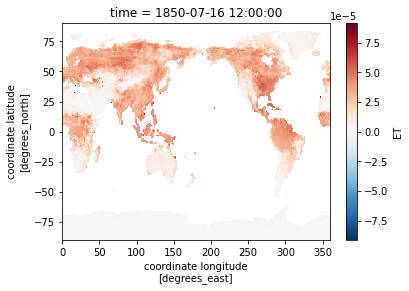

In [11]:
da.isel(time=6).plot()

In [14]:
# read in GCP (Global Carbon Project) data too 
# here .csv from 2016
import csv

GCP16 = '/glade/work/wwieder/gcp_data/GCP_2016.csv'

gcp16 = pd.read_csv(GCP16, sep=',')
#print(gcp16)
#Gives carbon fluxes from different earth surfaces for different years as estimated by GCP

#### Make weights for global sum

In [16]:
# ?? Would be nice to use cfunits  here ??
landUp = area * landfrac * 1e6      # area in km2, not m2; landfrac is percentage (tells you how much land is in grid area if area is coastal)
landUp.attrs['units'] = 'm^2'       # attributes unit to variables
area_wgt = landUp / landUp.sum()    # weighting for each grid cell
spy = 365 * 24 * 3600               # Convert  to annual fluxes (gC/m2/y), from gc/m2/s 

#### Convert monthly to annual

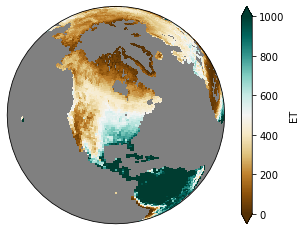

In [17]:
# apply iterates through all variables in a dataset and applies 
#   the function to each variable.
# ?? Would be nice to do this differently for fluxes & stocks ??
mean_dataset = dataset.apply(utils.weighted_annual_mean) * spy #apply function lets you do math on gridded data
mean_dataset.attrs['units'] = 'mm y-1'
#mean_dataset.attrs['units'] = 'gC m-2 y-1'
mean_dataset = mean_dataset.isel(time=slice(-10,None)).mean('time')
ET = mean_dataset.ET.where(mean_dataset.QVEGT>0)
ET.plot(subplot_kws=dict(projection=ccrs.Orthographic(-90, 45), facecolor="gray"),
    transform=ccrs.PlateCarree(), vmax=1000,vmin=0,cmap = 'BrBG',
) ;

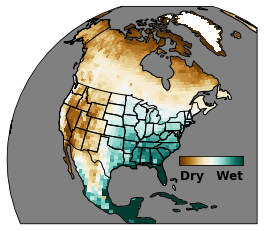

In [18]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
fig = plt.figure()
proj = ccrs.NearsidePerspective(-80, 32,
                                satellite_height=15785831, 
                                #false_easting=-2e10, false_northing=-2e10,
                               )
#Orthographic(central_longitude=-80.0, central_latitude=30.0, )
ax = plt.axes(projection = proj)

ax.set_extent([-160,-53,10,90])#, ccrs.PlateCarree())#[-180, 180, -90, 90], ccrs.PlateCarree())
# -- filled contours, ensemble mean, max snow in first decade ==
cf = ax.pcolormesh(ET.lon, ET.lat, ET, 
                   vmin=50,vmax=900, cmap = 'BrBG',#cmap='terrain_r',
                   transform=ccrs.PlateCarree());

#cax = fig.add_axes([0.36, 0.24, 0.15, 0.03])
cax = fig.add_axes([0.62, 0.33, 0.15, 0.03])
cb = plt.colorbar(cf,shrink=0.2,cax=cax,
                  orientation="horizontal")
cb.set_label(label=r'Dry   Wet',size=12,weight='bold')
cb.set_ticks([])
ax.coastlines(resolution='110m', edgecolor='black', zorder=9)
ax.add_feature(cfeature.OCEAN, facecolor='grey', zorder=1)
ax.add_feature(cfeature.STATES, edgecolor='black', zorder=10)
plt.show()

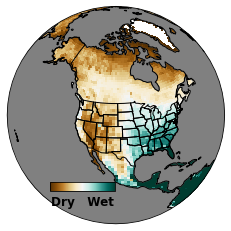

In [19]:
fig = plt.figure()
proj = ccrs.NearsidePerspective(-105, 45,
                                satellite_height=9785831, 
                                #false_easting=-2e10, false_northing=-2e10,
                               )
#Orthographic(central_longitude=-80.0, central_latitude=30.0, )
ax = plt.axes(projection = proj)

#ax.set_extent([-160,-53,10,90])#, ccrs.PlateCarree())#[-180, 180, -90, 90], ccrs.PlateCarree())
# -- filled contours, ensemble mean, max snow in first decade ==
cf = ax.pcolormesh(ET.lon, ET.lat, ET, 
                   vmin=50,vmax=900, cmap = 'BrBG',#cmap='terrain_r',
                   transform=ccrs.PlateCarree());

cax = fig.add_axes([0.36, 0.24, 0.15, 0.03])
cb = plt.colorbar(cf,shrink=0.2,cax=cax,
                  orientation="horizontal")
cb.set_label(label=r'Dry   Wet',size=12,weight='bold')
cb.set_ticks([])
ax.coastlines(resolution='110m', edgecolor='black', zorder=9)
ax.add_feature(cfeature.OCEAN, facecolor='grey', zorder=1)
ax.add_feature(cfeature.STATES, edgecolor='black', zorder=10)
plt.show()

In [20]:
ccc = np.zeros([11,3]);
ccc[0,:] = 84,48,5
ccc[1,:] = 140,81,10
ccc[2,:] = 191,129,45
ccc[3,:] = 223,194,125
ccc[4,:] = 246,232,195
ccc[5,:] = 245,245,245
ccc[6,:] = 199,234,229
ccc[7,:] = 128,205,193
ccc[8,:] = 53,151,143
ccc[9,:] = 1,102,94
ccc[10,:] = 0,60,48
ccc = matplotlib.colors.ListedColormap(ccc/256)

/glade/work/eschlerm/opt/miniconda/envs/lens-py/lib/python3.7/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/glade/work/eschlerm/opt/miniconda/envs/lens-py/lib/python3.7/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_ocean.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/glade/work/eschlerm/opt/miniconda/envs/lens-py/lib/python3.7/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_rivers_lake_centerlines.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/glade/work/eschlerm/opt/miniconda/envs/lens-py/lib/python3.7/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_coastline.zip
  w

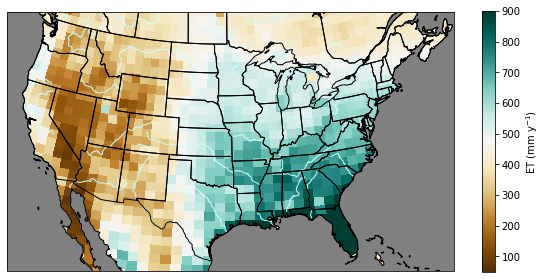

In [21]:
conus_proj = ccrs.LambertConformal(central_longitude=-96,central_latitude=39.0)
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(1,1,1,projection=conus_proj)
ax.set_extent([-120,-70,22,50])

# -- filled contours, ensemble mean, max snow in first decade ==
cf = ax.pcolormesh(ET.lon, ET.lat, ET, 
                   vmin=50,vmax=900, cmap = 'BrBG',#cmap='terrain_r',
                   transform=ccrs.PlateCarree());
#cf = ax.pcolormesh(dsREG2.lon, dsREG2.lat, dsREG2.H2OSNO.isel(ens=1, time=slice(0,120)).max(dim='time'), 
#                 transform=ccrs.PlateCarree());
cb = plt.colorbar(cf, shrink=0.6,label=r'ET (mm y$^{-1}$)')
#cb.ax.set_title(r'mm y$^{-1}$')
#, rotation=0, position=(1,1)
#ax.set_title("mean ET");

ax.add_feature(cfeature.COASTLINE,zorder=2)
ax.add_feature(cfeature.OCEAN, facecolor='grey', zorder=1)
#ax.add_feature(cfeature.LAKES, facecolor='grey')
ax.add_feature(cfeature.RIVERS, edgecolor='#CCFEFF')
ax.add_feature(cfeature.LAND, facecolor='#FFE9B5')
ax.add_feature(cfeature.STATES, edgecolor='black', zorder=10)

plt.plot(transform=ccrs.PlateCarree())
plt.show()

#### Calculate global sums

In [22]:
# ?? This could also be done regionally (see Paul's comments on google doc) ??
mean_wgt = mean_dataset * landUp
ann_glob = mean_wgt.sum(dim=('lat','lon')) * 1e-15 #convert to Pg/y
ann_glob.attrs['units'] = 'Pg C y^-1'
print(ann_glob)

<xarray.Dataset>
Dimensions:  ()
Data variables:
    ET       float64 63.87
    QVEGT    float64 34.11
Attributes:
    units:    Pg C y^-1


-----------------------------
### Make a line plot

In [23]:
from scipy import signal

#quick plot of raw and detrended data
temp = ann_glob.isel(time=slice(109,-1))
#plt.plot(temp.coords['time.year'], temp[var], '-' )
temp_DT = signal.detrend(temp[var])  # still need to use get so detrend works
agr_DT  = signal.detrend(gcp16.AGR)
Land_DT  = signal.detrend(gcp16.Land)
plt.plot(temp.coords['time.year'], temp_DT, '-' ,lw=2)
plt.plot(gcp16.Year, - agr_DT, '-' )
plt.plot(gcp16.Year, Land_DT, '-' )
plt.axhline(0, color='black', lw=1)
plt.legend(labels=('CLM','AGR_gcp16','LAND_gcp16'),frameon = False);

print(var)
print(np.std(temp_DT))

print('AGR')
print(np.std(agr_DT))

print('Land')
print(np.std(Land_DT))


ValueError: Dimensions {'time'} do not exist. Expected one or more of Frozen({})

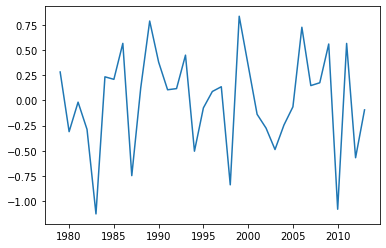

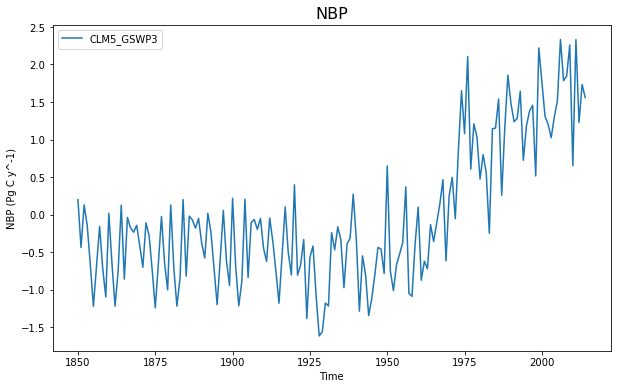

In [10]:
# Create a nicer figure
fig = plt.figure(figsize=(10, 6))

# Ask, out of a 1x1 grid, the first axes.
ax = fig.add_subplot(1, 1, 1)

# Plot times as x-variable and temperatures as y-variable
ax.plot(ann_glob.coords['time.year'], ann_glob[var], label=model)
# Add some labels to the plot
ax.set_xlabel('Time')
ax.set_ylabel(var+' (' + ann_glob.attrs['units'] +')')
ax.set_title(var, fontdict={'size':16})
ax.legend(loc='upper left');

------------------------
### Now make a map!

In [9]:
# making a data array, because cyclic_dataarray currently set up that way
x1= mean_dataset.isel(time=slice(0,10)).mean('time')[var] # Climatology for first 10 years of data
x = mean_dataset.isel(time=slice(-10,None)).mean('time')[var] # Climatology for last 10 years of data
xdiff = x - x1

xinit     = x1 * landUp
xfin      = x  * landUp
xdelta    = xdiff * landUp

glob_init   = xinit.sum(dim=('lat','lon')) * 1e-15 #convert to Pg/y
glob_fin    = xfin.sum(dim=('lat','lon')) * 1e-15 #convert to Pg/y
glob_change = xdelta.sum(dim=('lat','lon')) * 1e-15 #convert to Pg/y
print(glob_init, glob_fin, glob_change)

# Then add cyclic point, ?? is there a better way to do this ??
x1= utils.cyclic_dataarray(x1)  
x = utils.cyclic_dataarray(x)
xdiff = utils.cyclic_dataarray(xdiff)
lat = x.coords['lat']
lon = x.coords['lon']

<xarray.DataArray ()>
array(97.88563119) <xarray.DataArray ()>
array(121.24235673) <xarray.DataArray ()>
array(23.35672554)


/glade/u/home/wwieder/miniconda3/envs/python-tutorial/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


<Figure size 360x252 with 0 Axes>

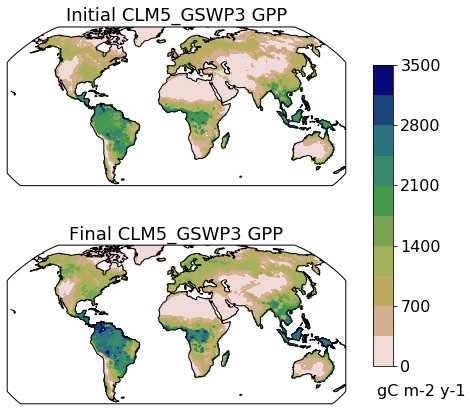

In [10]:
import matplotlib.colors as colors
import cartopy.feature as cfeature

norm = colors.Normalize(vmin=0., vmax=3.5e3)
norm(x.mean())

# modified from https://unidata.github.io/MetPy/latest/examples/Four_Panel_Map.html
crs = ccrs.Robinson()#central_longitude=305.0)

# Function used to create the map subplots
def plot_background(ax):
    ax.set_global()
    ax.coastlines()
    #ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=0.5)
    return ax

levels = np.linspace(0, 3500, 11)
fig = plt.figure(figsize=(5, 3.5),constrained_layout=True);
fig, axarr = plt.subplots(nrows=2, ncols=1, figsize=(10, 6), constrained_layout=True,
                          subplot_kw={'projection': crs})

axlist = axarr.flatten()
for ax in axlist:
    plot_background(ax)
    ax.set_extent([-155, 60, -25, 60])  # I really don't understand how this works??
#    ax.set_extent([-150, 60, -25, 60])


# upper plot
cf0 = axlist[0].contourf(lon, lat, x1, levels=levels, norm=norm, cmap='gist_earth_r',
                 transform=ccrs.PlateCarree());
axlist[0].set_title('Initial '+model+' '+var, fontsize=18)
axlist[0].set_axis_off()

# lower plot
cf1 = axlist[1].contourf(lon, lat, x, levels=levels, norm=norm, cmap='gist_earth_r',
                 transform=ccrs.PlateCarree());
axlist[1].set_title('Final '+model+' '+var, fontsize=18);
axlist[1].set_axis_off()

# add common colorbar
cbar = fig.colorbar(cf1, ax=axlist.ravel().tolist(), 
                    orientation='vertical', shrink=0.80, pad=0)
#cbar.set_label('gC/m2/y', size=18, orientation='horizontal')
cbar.ax.tick_params(labelsize=16) 
ax = cbar.ax
ax.text(0.2,-0.1,mean_dataset.attrs['units'], size=16,rotation=0)
plt.show();

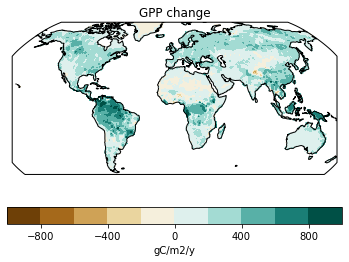

In [11]:
# Now make a difference map
norm = colors.Normalize(vmin=-1000., vmax=1000.)
norm(xdiff.mean())
levels = np.linspace(-1e3, 1e3, 11)

ax = plt.axes(projection=ccrs.Robinson())
ax.set_global()
ax.coastlines()
ax.set_extent([-155, 60, -25, 60])  # I really don't understand how this works??

cs = ax.contourf(lon, lat, xdiff, levels=levels, norm=norm, cmap='BrBG',
                 transform=ccrs.PlateCarree());

# add colorbar.
cbar = plt.colorbar(cs, orientation='horizontal')
cbar.set_label('gC/m2/y')

ax.set_title(var + " change")
plt.show();